In [1]:
from databroker.v1 import Broker
db = Broker.named('csx')


from csxtools.utils import get_fastccd_images,get_fastccd_flatfield
from csxtools.ipynb import image_stack_to_movie, show_image_stack  # FOUND MOVIE and should be working again

import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
def browse_images(res,title='Frame'):
    N = len(res)
    def view_image(i=0):
        im.set_data(res[i])
        ax.set_title(f'{title} {i}')
        fig.canvas.draw_idle()
    interact(view_image, i=(0, N-1))

OBJECT CACHE: Will use up to 121_499_065_344 bytes (15% of total physical RAM)


# Using FCCD data at CSX with csxtools and scikit-beam
## Notebooks created by CSX beamline staff
## Trust only the [source](https://github.com/ambarb/csx_primer_notebooks/blob/main/CSX_fccd_data.ipynb)
## Report issues (aside from github rendering)

In [2]:
import csxtools
print(f'{csxtools.__version__=}')
import skbeam
print(f'{skbeam.__version__=}')

csxtools.__version__='0.1.16'
skbeam.__version__='0.0.24'


## Flatfield is broken because FCCD is broken.  

Use the fix in the next cell to replace the library's broken function:
- if you want to make a flatfield correction set `half = True` in the function call

In [3]:
def get_fastccd_flatfield(light, dark, flat=None, limits=(0.6, 1.4), half=False, half_args = (7, 486)):
    """MODIFIED from csxtools original: Calculate a flatfield 
    This routine calculates the flatfield using the
    :func:calculate_flatfield() function after obtaining the images from
    the headers.
    Parameters
    ----------
    light : databroker header
        The header containing the light images
    dark : databroker header
        The header from the run containin the dark images
    flat : flatfield image (optional)
        The array to be used for the initial flatfield
    half : calculate for just the "good" half - hard coded
        Default is False
    half_args : Tuple for exluding entire sides of detector (left versus right)
        Left side is refers the the left side of the image after raw data is 
        processed with get_fastccd_images().  Default arguments are for the left side
        using the FrameStore mode.
    Returns
    -------
    array_like
        Flatfield correction
    """
    images = get_images_to_3D(get_fastccd_images(light, dark, flat))
    images = stackmean(images)
    if half == True:
        #rows because "super columns" are the large 10 pixel bins, but camera is on side.
        row_start, row_stop = half_args
        images[:,row_start:row_stop] = np.nan
        #plt.figure()
        #im = plt.imshow(images, vmin =0, vmax = 500)
        #cbar = plt.colorbar(im)
        #cbar.set_label('ADU gain corrected')
    flat = calculate_flatfield(images, limits)
    removed = np.sum(np.isnan(flat))
    if removed != 0:
        logger.warning("Flatfield correction removed %d pixels (%.2f %%)" %
                       (removed, removed * 100 / flat.size))
    return flat

    

In [4]:
scan_no = 126365  ; descript = ' long static test'
scan_no = 126360  ; descript = ' 4 um per s'

bgnd1 = None #db[h.start['scan_id']-1]#None #
bgnd2 = None #db[h.start['scan_id']-2]#None #
bgnd8 = db[126362]

use_flatfield = False

if use_flatfield == 0:
    ff = None
else:
    print('for flatfield uncomment function and customize with your scans')
    pass
    #ff =  get_fastccd_flatfield()

## Now to retreive data

### Set up

In [5]:
#### PILOT DATA for test ###
### This data is generated by a static sample pattern in saxs geometery, but Q does not matter for this purpose.  Note that there are some 'problems' using the data sets so this is not perfect for fine analysis - just code testing

### 
scan_no = 126365  ; descript = ' long static test'
scan_no = 126360  ; descript = ' 4 um per s'

bgnd1 = None #db[h.start['scan_id']-1]#None #
bgnd2 = None #db[h.start['scan_id']-2]#None #
bgnd8 = db[126362]

use_flatfield = False

In [6]:
########### working part, don't touch
h = db[scan_no] # h is for header

tbl=h.table() #get everything but IMAGES from FCCD
tbl_bl = h.table('baseline')

ADUpPH = 30*np.nanmean(tbl_bl.pgm_energy_readback)/930
frametime = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_period']

if use_flatfield == 0:
    ff = None

### Normalize images
* single point count (like XPCS)
```python
    stack = get_fastccd_images(h, (bgnd8, bgnd2, bgnd1), flat=ff, tag='fccd_image')
    images = stack[0]  #THIS IS ONE BIG STACK
```


* multi-point count (spec "timescan" or scan)
```python
    images = get_fastccd_images(header, (bgnd8, bgnd2, bgnd1), flat=None)
    stack = get_images_to_4D(images)
    images =stack
```

In [7]:
stack = get_fastccd_images(h, (bgnd8, bgnd2, bgnd1), flat=ff, tag='fccd_image')
images = stack[0]  #THIS IS ONE BIG STACK
pixels_in_ADU = True

Missing dark image for gain setting 2
Missing dark image for gain setting 1


In [8]:
images = images[:] / ADUpPH 
pixels_in_ADU = False

APPROXIMATE ADU per photon:			25.2 ADU
Max number photon in 1 image pixel (0.2575s):	392.6 ph


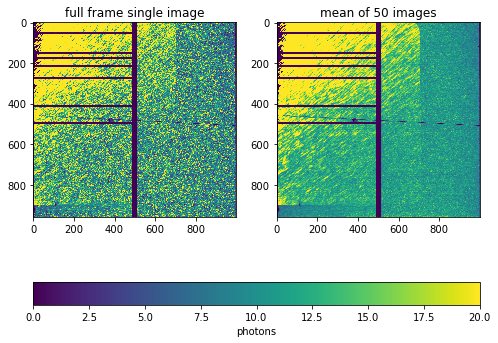

In [9]:
frame_beg = 0
frame_end = 50
floor = 0#np.nanmin(images[1])*2
ceiling = 20#np.nanmax(images[1])

avg_frames = np.nanmean(images[frame_beg:frame_end,:,:],axis=0)

fig, axes = plt.subplots(1,2,figsize=(8,8))
im=axes[0].imshow(images[frame_beg], vmin=floor, vmax=ceiling,
                  cmap='viridis', interpolation='none')
axes[0].set_title('full frame single image')
axes[1].imshow(avg_frames, vmin=floor, vmax=ceiling,
               cmap='viridis', interpolation='none')
axes[1].set_title('mean of {} images'.format(images[frame_beg:frame_end,:,:].shape[0]))

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),orientation="horizontal")
if pixels_in_ADU is True:
    cbar.set_label('ADU')
else:
    cbar.set_label('photons')
maxphoton=np.nanmax(images[frame_beg])
exposuretime=h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_time']
SUMphoton=np.nansum(np.nansum(images[1,:,:],axis=1),axis=0)

print(f'APPROXIMATE ADU per photon:\t\t\t{ADUpPH:2.1f} ADU')
print(f'Max number photon in 1 image pixel ({exposuretime:.4f}s):\t{maxphoton:2.1f} ph')

### Movie 

In [10]:
print(f'The colorbar units are {pixels_in_ADU}')

The colorbar units are False


In [11]:
image_stack_to_movie(images, vmin=floor, vmax=ceiling)

### Interactive exploration
* currently broken, looking into fix until matplotlib is fixed for `%matplotlib widget`
* `plt.ion()` does work in some cases, but I haven't been successful here

In [12]:
%matplotlib widget

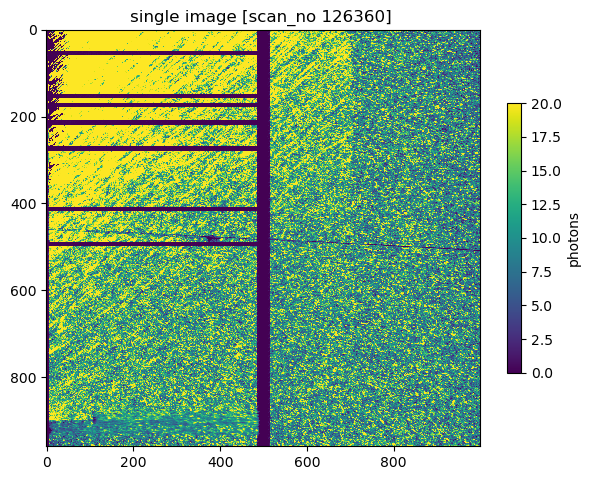

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set(title='single image [scan_no %s] ' %(h['start']['scan_id']))
im=ax.imshow(images[1],vmin=floor, vmax=ceiling,#np.max(sub_images[1]), 
             cmap='viridis', interpolation='none')
cbar = fig.colorbar(im, ax=ax,shrink=.5, orientation='vertical')
if pixels_in_ADU is True:
    cbar.set_label('ADU')
else:
    cbar.set_label('photons')

### Only works if plot above is interactive

In [14]:
browse_images(images)

interactive(children=(IntSlider(value=0, description='i', max=199), Output()), _dom_classes=('widget-interact'…

# Essential libraries and functions and quantities for XPCS
```python
import skbeam.core.correlation as corr
import skbeam.core.roi as roi


## CONVERT TO PHOTONS and getting dt for XPCS
ADUpPH = 30*np.nanmean(tbl_bl.pgm_energy_readback)/930 
frametime_dt = h.descriptors[0]['configuration']['fccd']['data']['fccd_cam_acquire_period'] 

## waterfall
roi.kymograph(images,rois) 

## one-time
num_levels = 4 #16# 1
num_bufs =  8 #6#Asub_images.shape[0] #4
# 1 and number of images respectively, for brute force got levels and buffers
g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, rois, images)

## two-time
num_bufs_tt = images[f_beg:f_end,:,:].shape[0]
num_levels_tt = 1
C2, lag_steps_tt, _state = corr.two_time_corr(rois, images[f_beg:f_end,:,:], images[f_beg:f_end,:,:].shape[0], num_bufs_tt, num_levels_tt)  

```

### Defining images for XPCS
- 3D array that is F-type 
```python
images.shape = (frames, vertical_pixels, horizontal_pixels)
```
- if you are only computing XPCS for 200x200 area, then the code is more performant if you make input the same size
- want to ignore a frame?  make pixel values = np.nan

### Defining roi for XPCS
- 2D array with integer mapping for pixel grouping
    - array must by the same vertical and horzizontal pixels as the images
    - 0 is not computed ever (map pixels to ignore all the time as 0)
    - if pixels in the input XPCS data are always nan, make the associate roi pixel = 0
- Various examples of how to use `roi`:
    - https://github.com/scikit-beam/scikit-beam-examples/blob/master/demos/Generate_ROI_labeled_arrays.ipynb
    - note pie-slicing is broken with a fix to be pushed soon

